# PA005: High Value Customer Identification

# 0.0. Planejamento da Solução ( IOT )

## Input - Entrada

### O problema de negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )

## Output - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras )
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0. Imports

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns

import umap.umap_ as umap

from IPython.display import HTML
from matplotlib import pyplot as plt

from sklearn import cluster as c
from sklearn import metrics as m

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

C:\Users\ferna\AppData\Local\Temp\ipykernel_9740\1320104767.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas  as pd
d:\ProgramaFidelidade\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1. Helper Functions

In [5]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [8]:
# load data
df_raw = pd.read_csv('./datasets/Ecommerce.csv', encoding='latin-1')

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

# <font color='red'> 1.0. Descrição dos dados </font>

In [9]:
df1 = df_raw.copy()

## 1.1. Rename columuns

In [10]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions

In [11]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


## 1.3. Data types

In [12]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [13]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [14]:
# remova na
df1 = df1.dropna( subset=['description', 'customer_id'] )
print( 'Removed data: {:.2f}'.format( 1-( df1.shape[0] / df_raw.shape[0] ) ) )

Removed data: 0.25


In [15]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6. Change dtypes

In [16]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [17]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 1.7. Descriptive Statistics

# <font color='red'> 2.0. Feature Engineering </font>

In [18]:
df2 = df1.copy()

## 2.1. Feature Creation

In [19]:
# data reference
df_ref = df2.drop( ['invoice_no', 'stock_code', 'description', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates( ignore_index=True )

# Gross Revenue ( Faturamento ) quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )

# Recency - Last day purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

# Avg Ticket
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')

# <font color='red'> 3.0. Filtragem de Varivéis </font>

In [20]:
df3 = df_ref.copy()

# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

In [21]:
df4 = df3.copy()

# <font color='red'> 5.0. Data Preparation </font>

In [22]:
df5 = df4.copy()

# <font color='red'> 6.0. Feature Selection </font>

In [23]:
df6 = df5.copy()

# <font color='red'> 7.0. Hyperparameter Fine-Tunning </font>

In [24]:
X = df6.drop( columns=['customer_id'] )

In [25]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,5288.63,302,35,16.950737
1,3079.10,31,18,15.709694
2,7187.34,2,18,28.634821
3,948.25,95,5,33.866071
4,635.10,330,6,105.850000


In [26]:
clusters = [2, 3, 4, 5, 6, 7]

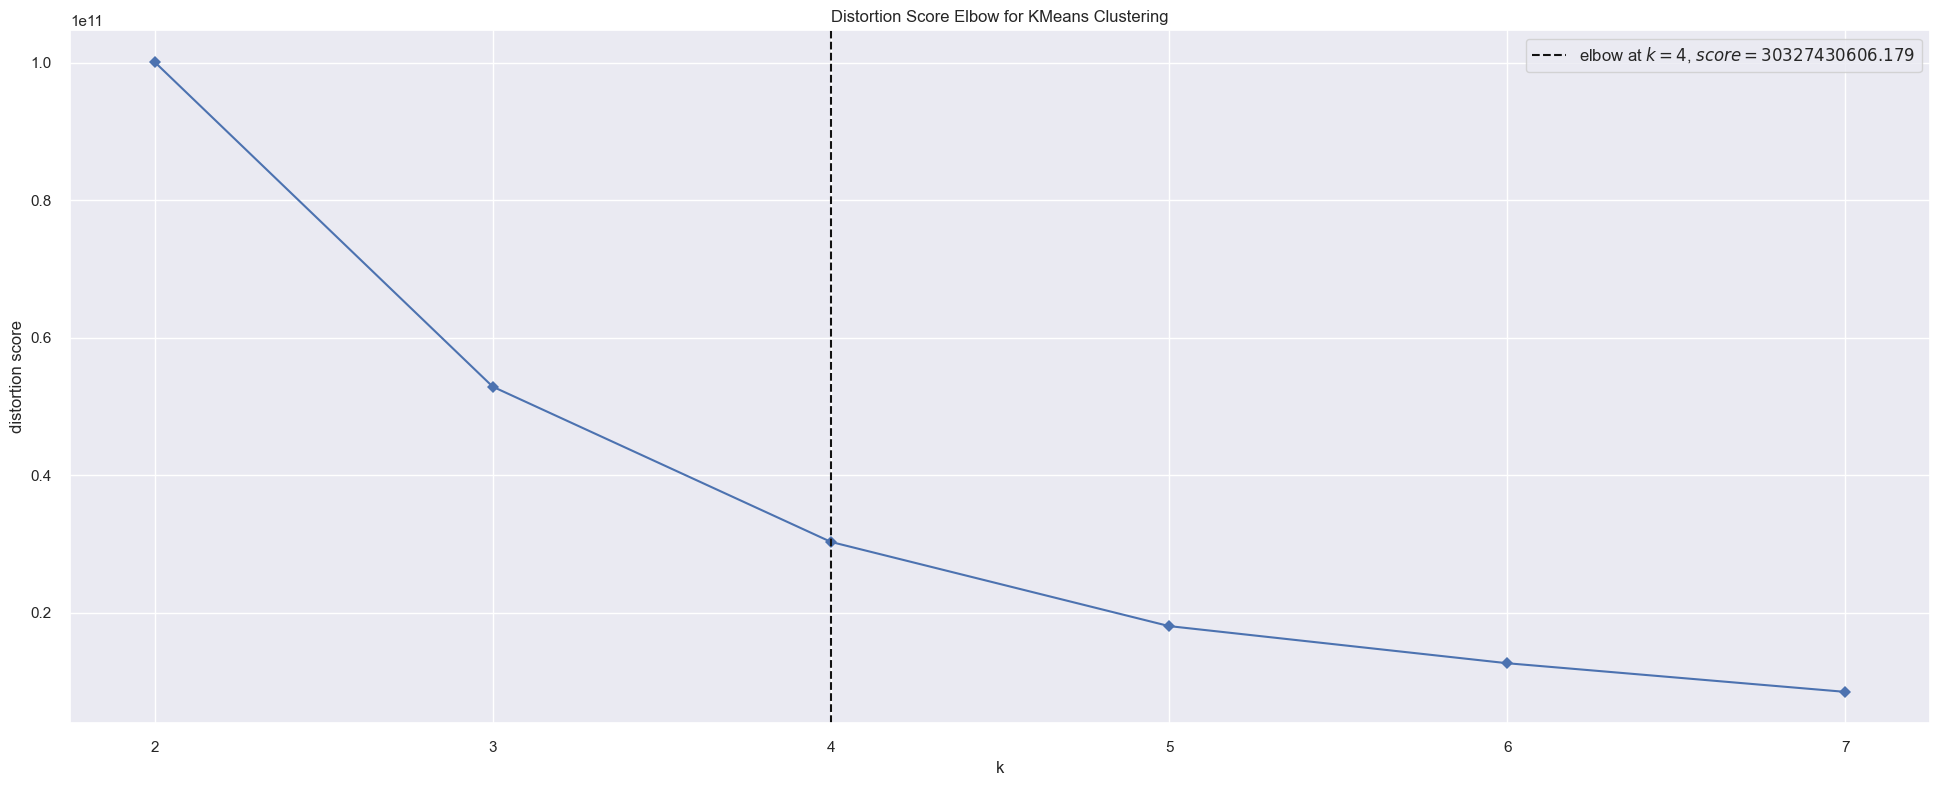

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit( X )
kmeans.show()

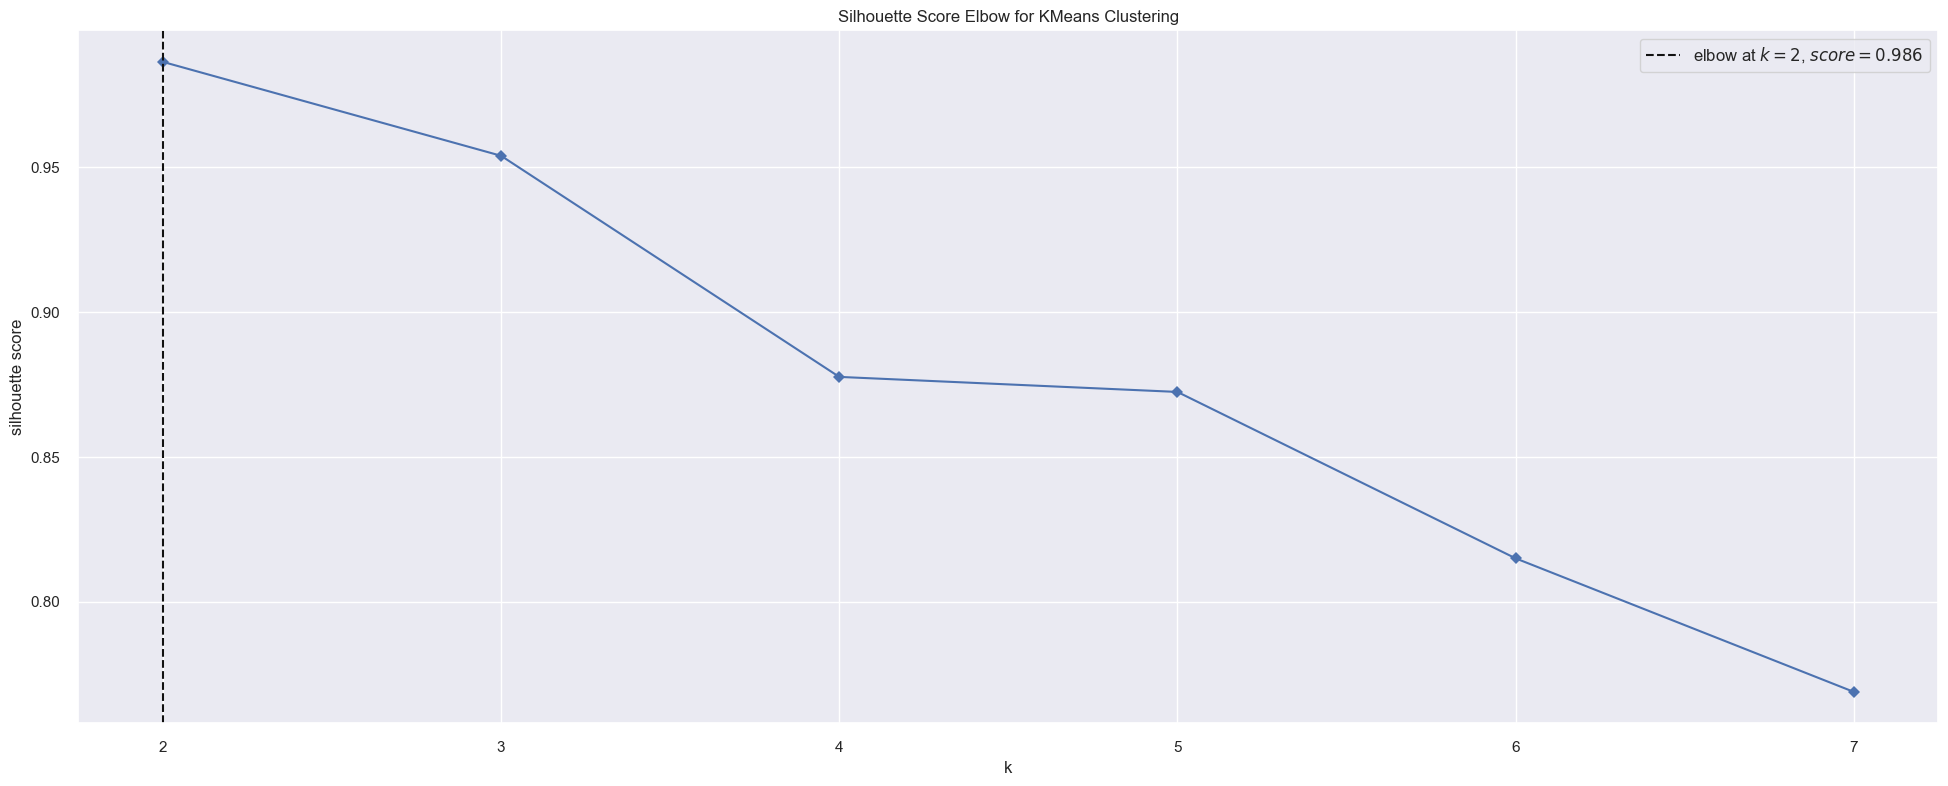

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [28]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

## 7.1. Silhouette Analysis

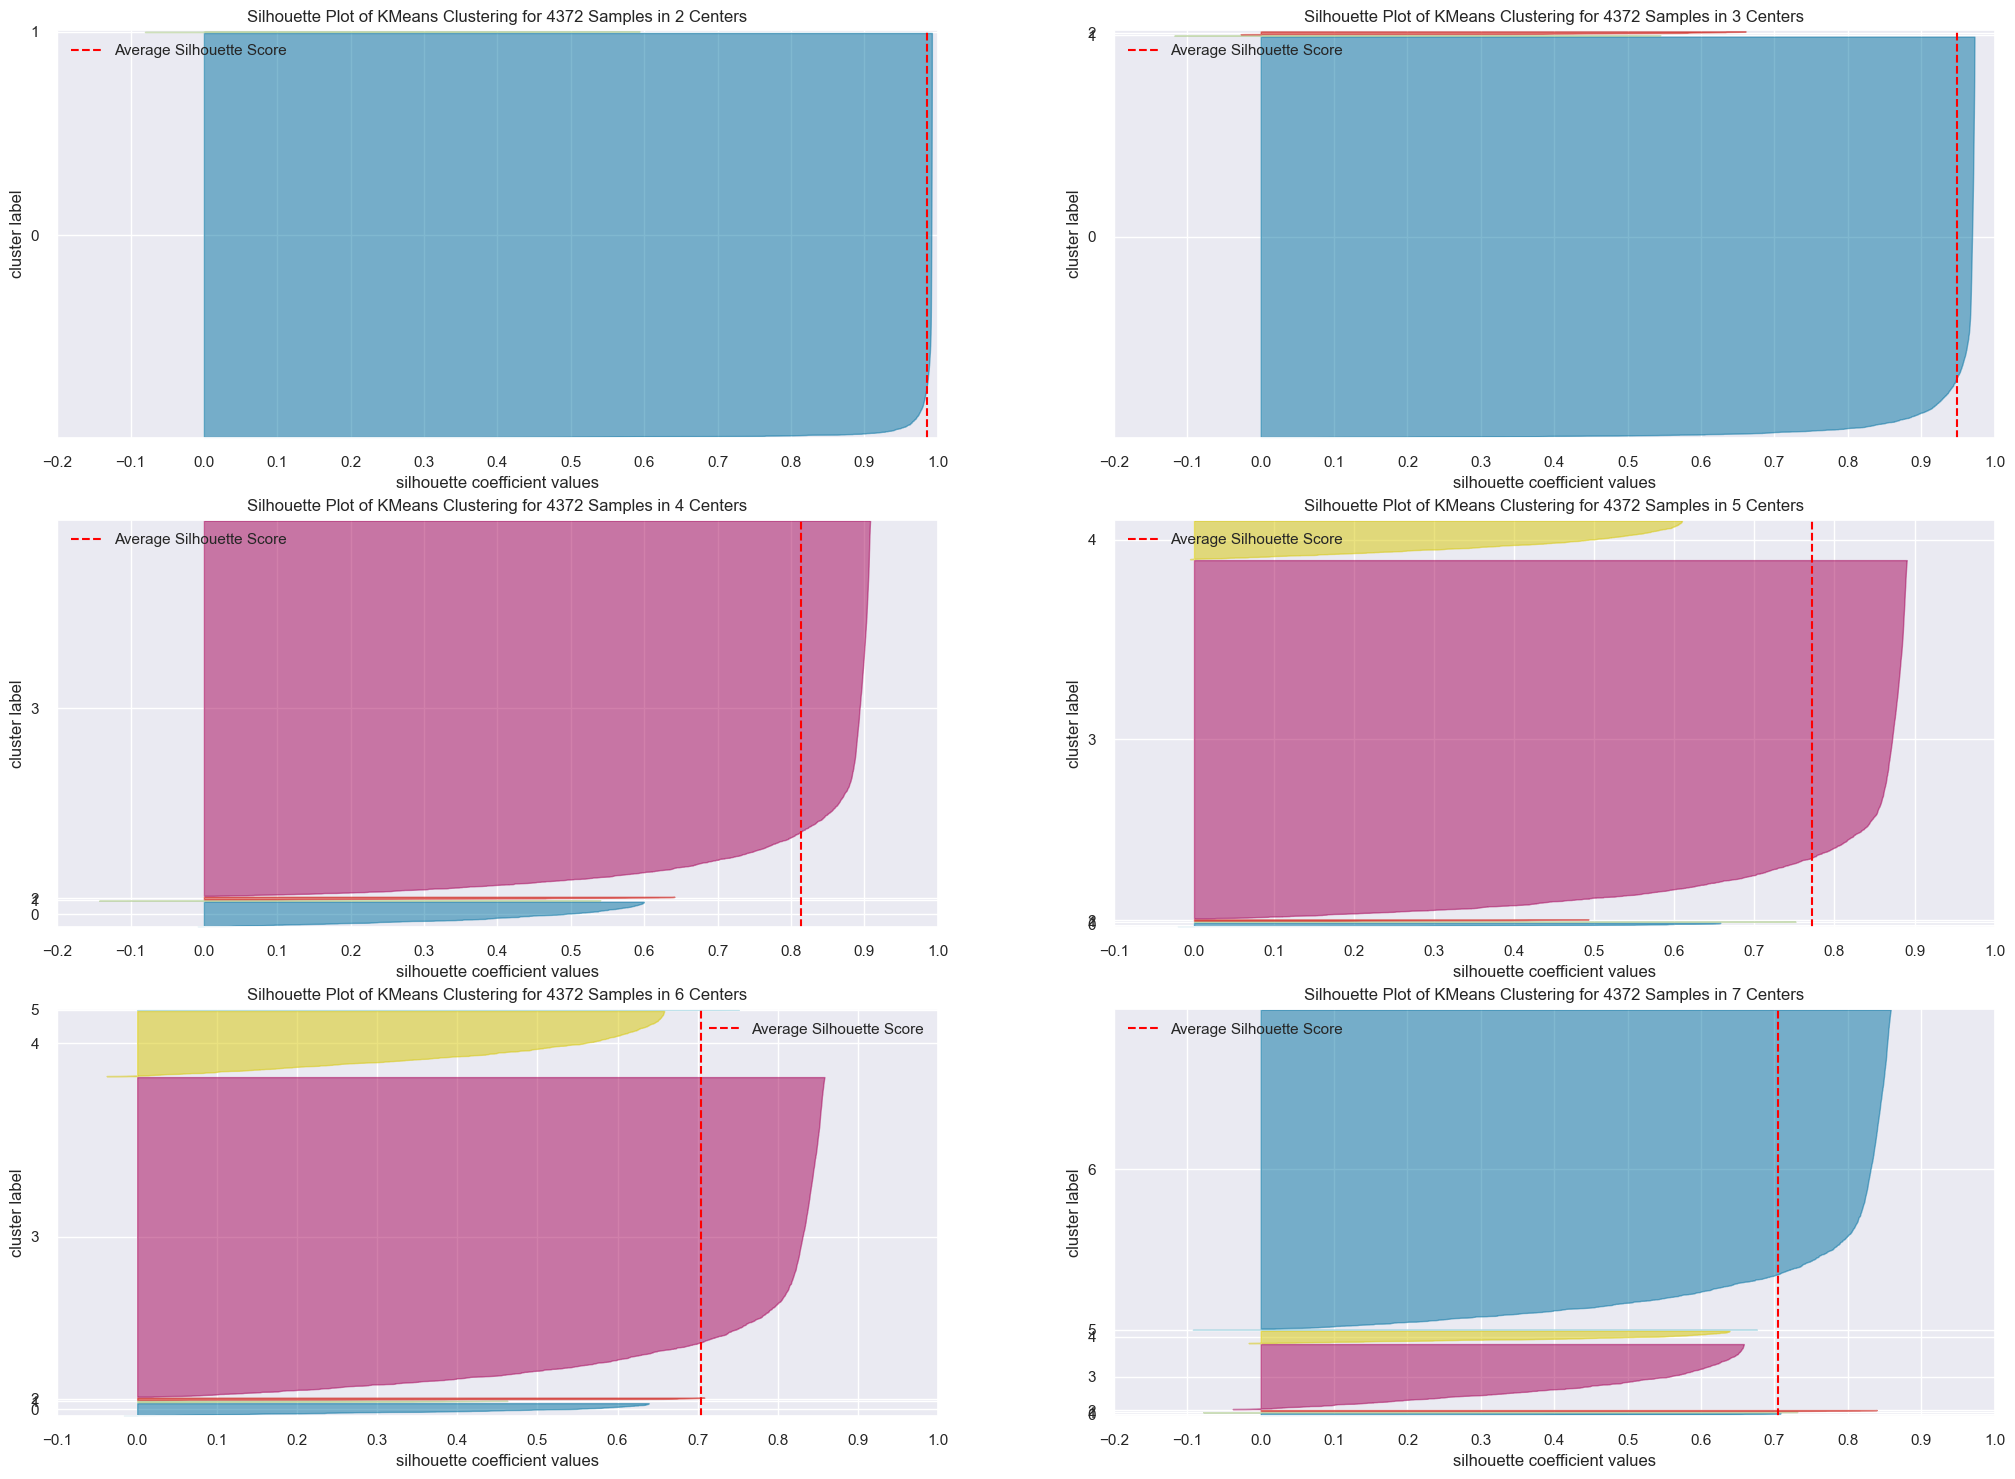

In [29]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# <font color='red'> 8.0. Model Training </font>

## 8.1. K-Means

In [30]:
# model definition
k = 4
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

### 8.2. Cluster Validation

In [31]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 40056254626.29973
SS value: 0.8139972028952444


# <font color='red'> 9.0. Cluster Analysis </font>

In [32]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,0
1,13047,3079.10,31,18,15.709694,3
2,12583,7187.34,2,18,28.634821,0
3,13748,948.25,95,5,33.866071,3
4,15100,635.10,330,6,105.850000,3


## 9.1. Visualization Inspection

d:\ProgramaFidelidade\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


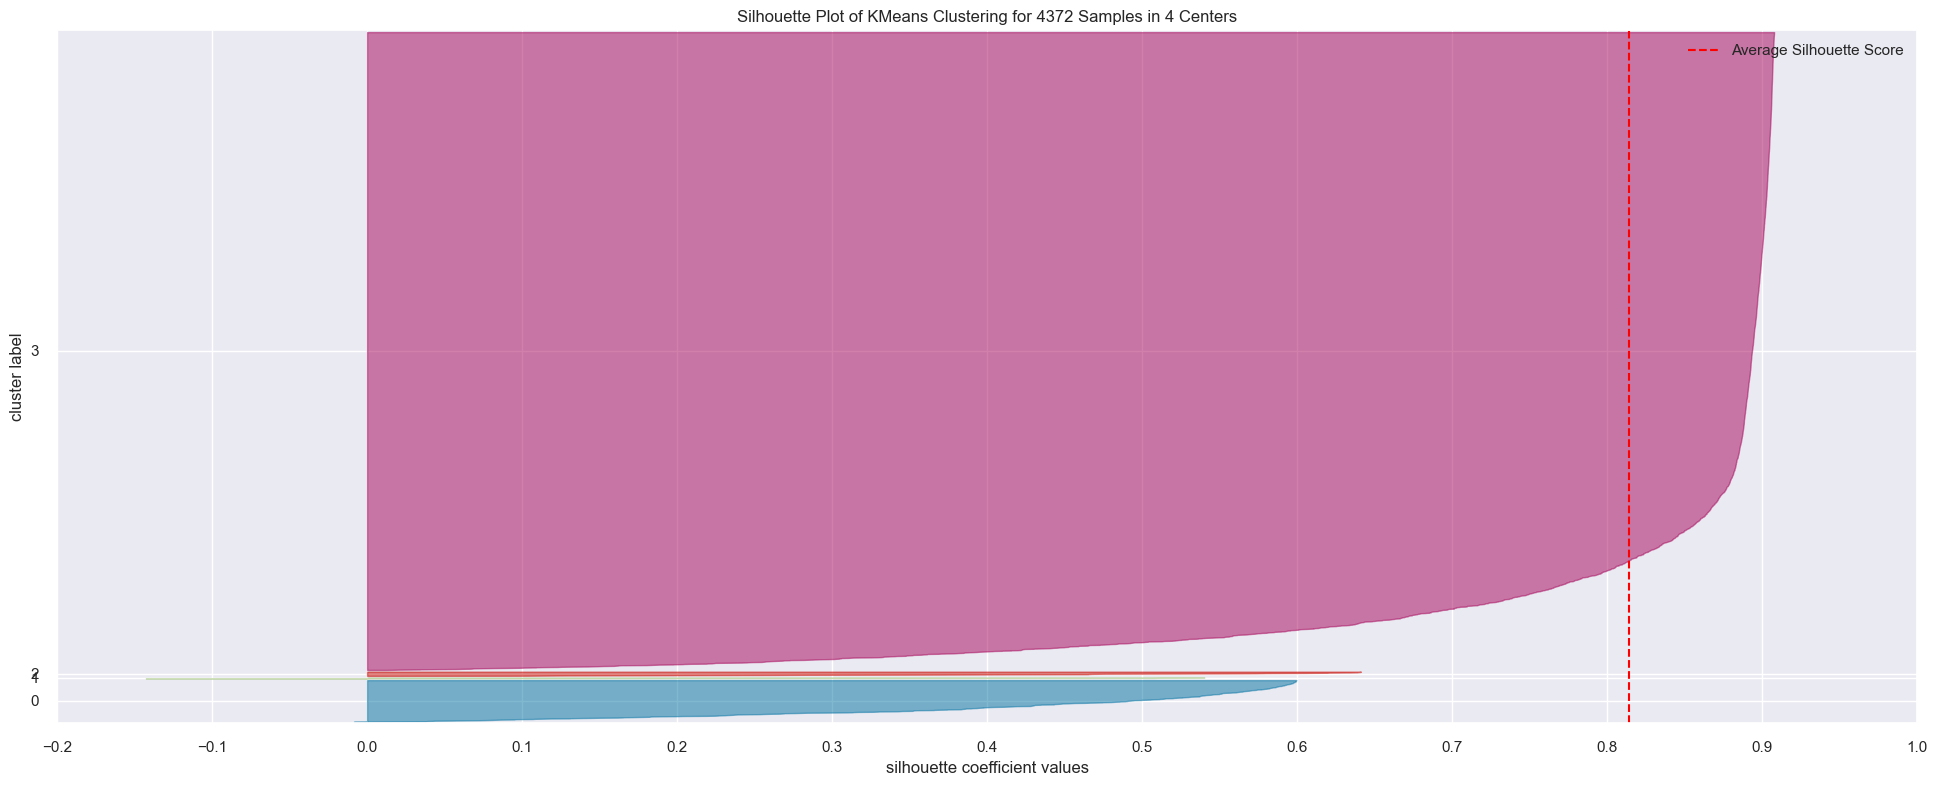

In [33]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
visualizer.fit( X )
visualizer.finalize()

## 9.2. 2d plot

d:\ProgramaFidelidade\.venv\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\ProgramaFidelidade\.venv\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\ProgramaFidelidade\.venv\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\ProgramaFidelidade\.venv\Lib\site-packages\seaborn\_base.py:9

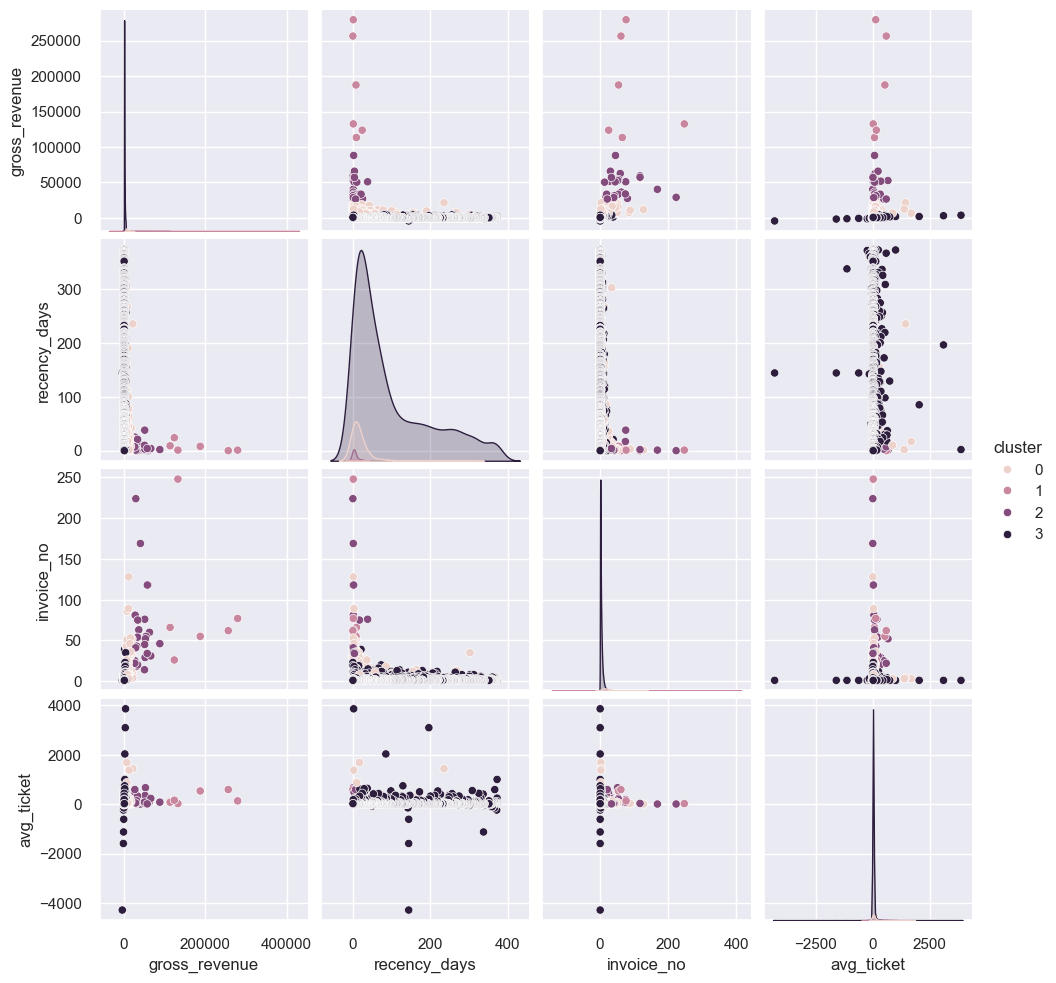

In [34]:
df_viz = df9.drop( columns='customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster' )

## 9.3. UMAP


d:\ProgramaFidelidade\.venv\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

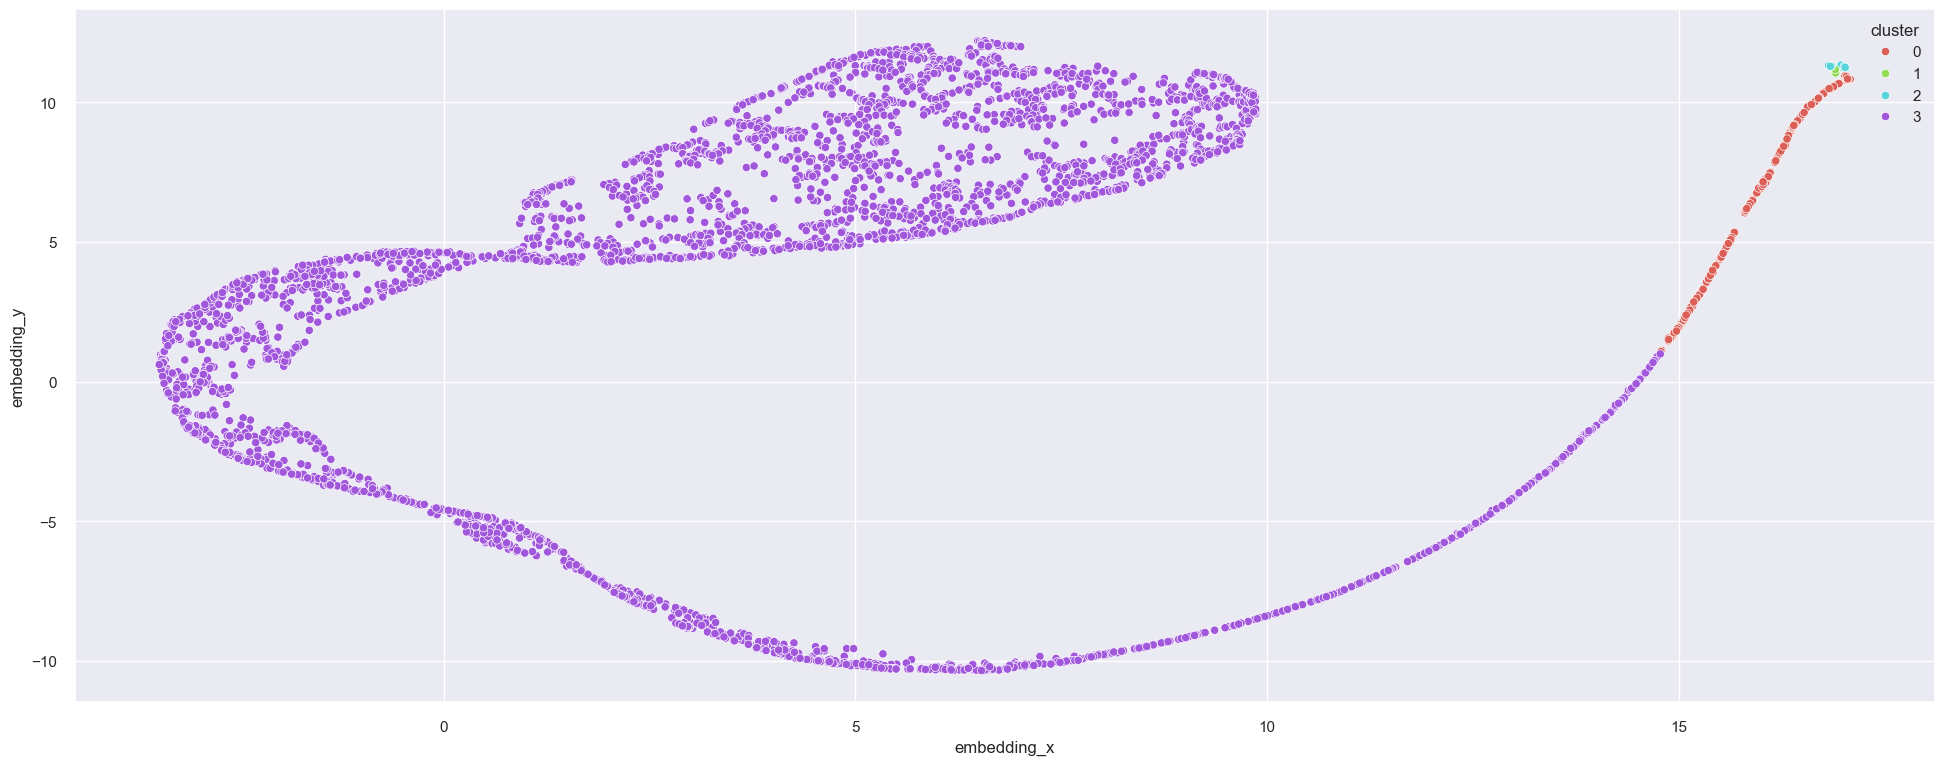

In [39]:
reducer = umap.UMAP( n_neighbors=80, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )

## 9.2. Cluster Profile

In [36]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,0
1,13047,3079.10,31,18,15.709694,3
2,12583,7187.34,2,18,28.634821,0
3,13748,948.25,95,5,33.866071,3
4,15100,635.10,330,6,105.850000,3


In [37]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,267,6.107045,8089.028652,20.280899,19.528090,62.783157
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,4071,93.115279,946.696250,96.969295,3.641120,25.359654


### Cluster 01:  ( Candidato à Insider )
    - Número de customers: 6 (0.14% do customers )
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $182.182,00 dólares
        
### Cluster 02: 
    - Número de customers: 31 (0.71 do customers )
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: $40.543,52 dólares
        
### Cluster 03: 
    - Número de customers: 4.335 (99% do customers )
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: $1.372,57 dólares

# <font color='red'> 10.0. Deploy To Production </font>